In [10]:
## IMPORTACIÓN GENERAL DE LIBRERIAS Y VISUALIZACIÓN DE DATOS (matplotlib y seaborn)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# XGBoost
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('default') 
plt.rcParams['figure.figsize'] = (15, 10)

In [11]:
# LECTURAS DE CSV YA PROCESADOS.
train1 = pd.read_csv('DATA/trainProcesado_patov5.csv')
test2 = pd.read_csv('DATA/testProcesado_patov5.csv')

In [12]:
# Nos quedamos con las columnas mas significativas
train = pd.DataFrame()
test = pd.DataFrame()
train = train1[['id','precio','mean', 'median', 'metroscubiertos_agrupada', 'provincia', 'ciudad', 'metrostotales_agrupada', 'tipodepropiedad', 'garages', 'banos', 'habitaciones', 'antiguedad_agrupada', 'LUJO', 'REMATE']]
test = test2[['id','mean', 'median', 'metroscubiertos_agrupada', 'provincia', 'ciudad', 'metrostotales_agrupada', 'tipodepropiedad', 'garages', 'banos', 'habitaciones', 'antiguedad_agrupada', 'LUJO', 'REMATE']]

In [13]:
# Copiamos el ID de test, y lo eliminamos
testID = pd.DataFrame()
testID['id'] = test['id']
test.drop('id',1,inplace=True)

In [14]:
# Vemos el resultado final
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 13 columns):
mean                        60000 non-null float64
median                      60000 non-null float64
metroscubiertos_agrupada    60000 non-null int64
provincia                   60000 non-null int64
ciudad                      60000 non-null int64
metrostotales_agrupada      60000 non-null int64
tipodepropiedad             60000 non-null int64
garages                     60000 non-null int64
banos                       60000 non-null int64
habitaciones                60000 non-null int64
antiguedad_agrupada         60000 non-null int64
LUJO                        60000 non-null int64
REMATE                      60000 non-null int64
dtypes: float64(2), int64(11)
memory usage: 6.0 MB


In [15]:
# Vemos el resultado final
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 15 columns):
id                          240000 non-null int64
precio                      240000 non-null float64
mean                        240000 non-null float64
median                      240000 non-null float64
metroscubiertos_agrupada    240000 non-null int64
provincia                   240000 non-null int64
ciudad                      240000 non-null int64
metrostotales_agrupada      240000 non-null int64
tipodepropiedad             240000 non-null int64
garages                     240000 non-null int64
banos                       240000 non-null int64
habitaciones                240000 non-null int64
antiguedad_agrupada         240000 non-null int64
LUJO                        240000 non-null int64
REMATE                      240000 non-null int64
dtypes: float64(3), int64(12)
memory usage: 27.5 MB


# HyperOpt

In [22]:
# Optimizamos los hiper-parametros de xgboost mediante hyper-opt
# XGB parameters
xgb_reg_params = {
    'objective':        'reg:squarederror',
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [23]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [24]:
# Tratamiento de train para entrenamiento
Y = np.array(train['precio'])
X = train.drop('precio', axis = 1)
X.drop('id', axis = 1, inplace = True)

In [25]:
# Split 20/80 (%)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
# Ejecutamos el tuneo de los hiper-parametros
obj = HPOpt(trainX, testX, trainY, testY)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [1:01:16<00:00, 36.77s/it, best loss: 751168.9226365498]


In [59]:
# Separamos el resultado en results y trials
result = xgb_opt[0]
trials = xgb_opt[1]

# Imprimimos result
print(result)

{'colsample_bytree': 4, 'learning_rate': 1, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9804451348023119}


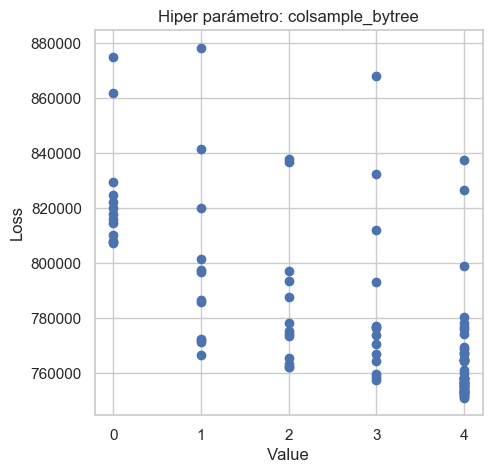

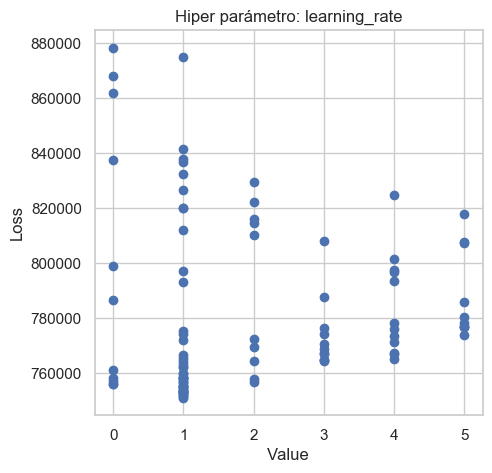

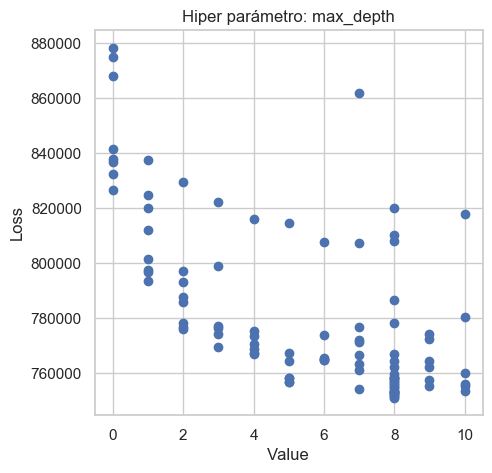

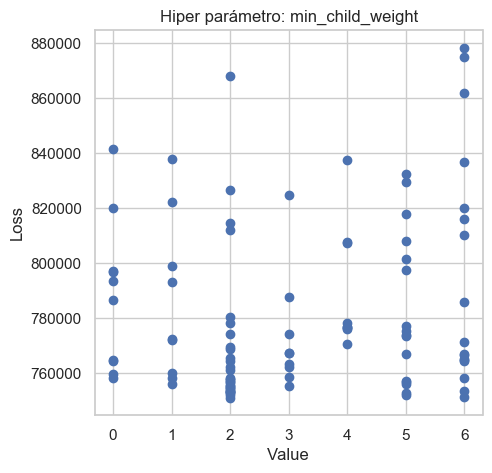

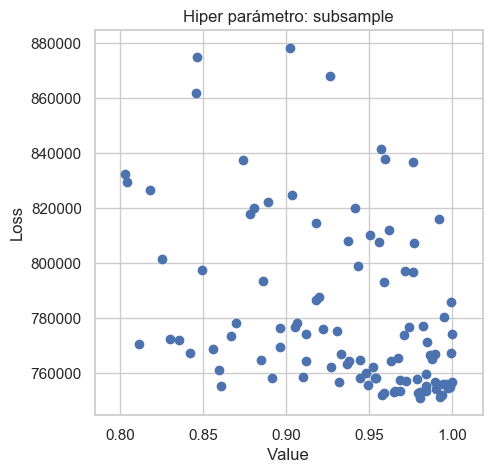

In [67]:
# Ploteamos las pruebas para todos los hiperparametros probados
for hyperParam in result:
    x = trials.vals[hyperParam]
    y = [x['loss'] for x in trials.results]
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.scatter(x, y)
    plt.title("Hiper parámetro: " + hyperParam)
    plt.xlabel('Value')
    plt.ylabel('Loss')
    plt.show()

# XGBOOST

In [117]:
# Instanciamos el xgb con el que vamos a hacer la prediccion
# Usamos los parametros encontrados con hyper-opt
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', 
                          n_estimators = 500,
                          min_child_weight = 5,
                          learning_rate = 0.05,
                          gamma = 0.2,
                          reg_lambda = 2,
                          max_depth = 5,
                          colsample_bytree = 0.5, 
                          subsample_bytree = 0.8)

In [118]:
# Entranamiento
xg_reg.fit(trainX,trainY)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.2,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=2, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, subsample_bytree=0.8,
             verbosity=1)

In [119]:
# Prediccion, test
y_pred = xg_reg.predict(testX)

# Calculamos el error absoluto.
errors = abs(y_pred - testY)

# Imprimimos el error.
print('Error:', round(np.mean(errors), 2), 'grados.')

Error: 450057.79 grados.


In [120]:
# Calculamos el porcentaje de error.
mape = 100 * (errors / testY)

# Calculate la precisión.
accuracy = 100 - np.mean(mape)
print('Precision:', round(accuracy, 2), '%.')

Precision: 79.87 %.


In [122]:
# Prediccion final
prediccion = xg_reg.predict(test)

In [124]:
## =================================================================================================
## ARMAMOS EN BASE A LA PREDICCIÓN QUE TENEMOS UN CSV PARA SUBIR A KAGGLE CON EL FORMATO INDICADO!
## =================================================================================================
submission = pd.DataFrame({ 'id': testID['id'], 'target': prediccion })
submission.to_csv("SUBMITS/008_G34_XGBoost_v1.csv", index=False)

# Feature Importance

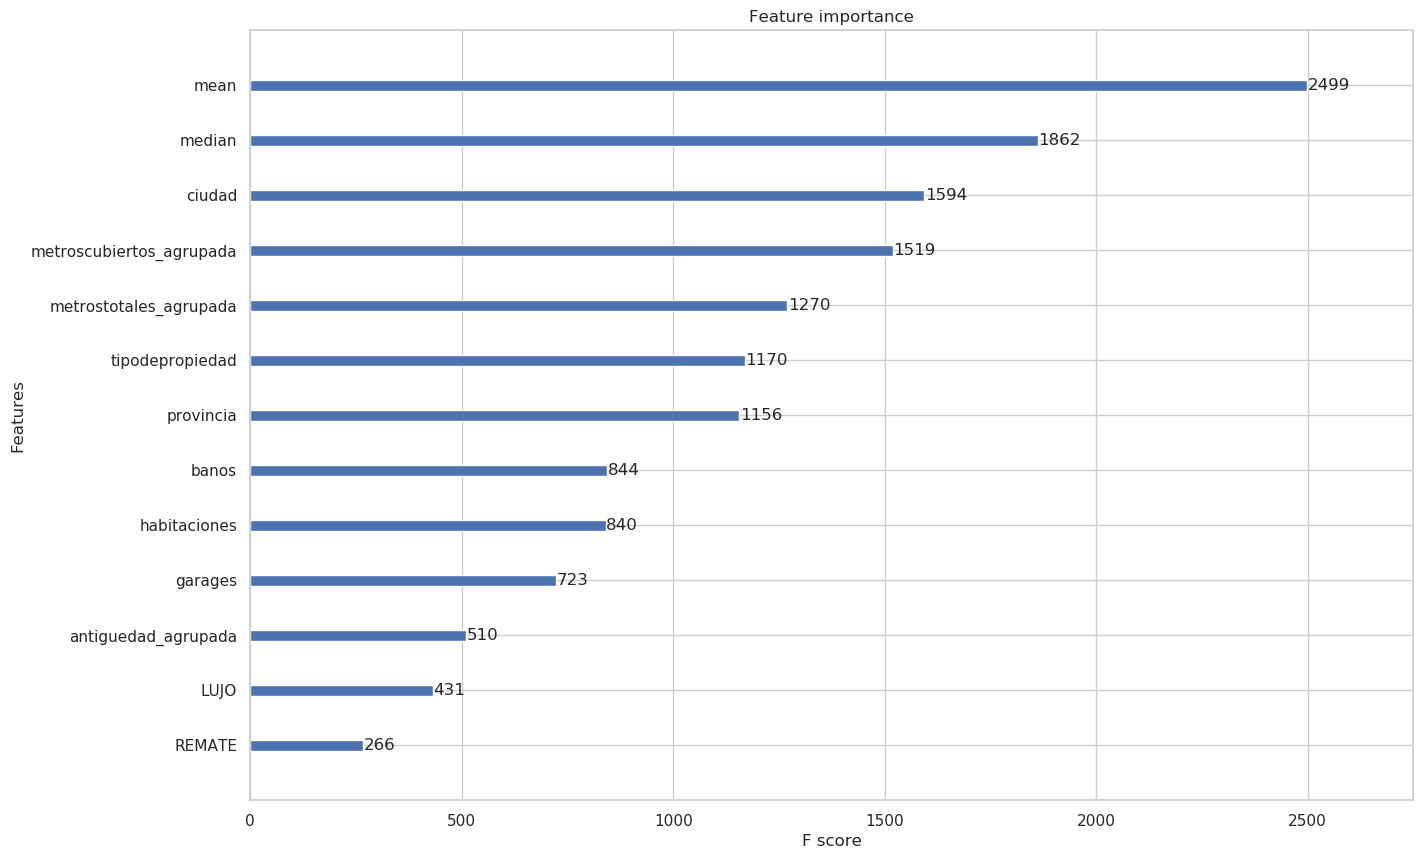

In [125]:
#Graficamos la importancia de los features utilizados en el algoritmo (top 30)
xgb.plot_importance(xg_reg, max_num_features=30)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()